### Image Colorization with OpenVino

This notebook demonstrates how to colorize images with OpenVINO using the Colorization model [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) or [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) based on the paper [Colorful Image Colorization](https://arxiv.org/abs/1603.08511).

![Let there be color](data/banner.png)


The idea here is given a grayscale image as input, the model hallucinates a plausible, vibrant & realistic colorized version of the image.

#### About Colorization-v2
* The colorization-v2 model is one of the colorization group of models designed to perform image colorization.
* Model was trained on ImageNet dataset.
* Model consumes as input L-channel of LAB-image and give as output predict A- and B-channels of LAB-image.

#### About Colorization-siggraph
* The colorization-siggraph model is one of the colorization group of models designed to real-time user-guided image colorization.
* Model was trained on ImageNet dataset with synthetically generated user interaction.
* Model consumes as input L-channel of LAB-image and yields output predict A- and B-channels of LAB-image.

Check out [colorization](https://github.com/richzhang/colorization) repository for more details.

## Imports

In [ ]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

## Configurations

* `PRECISION` - {FP16, FP32}, default: FP16 
* `MODEL_DIR` - directory where the model is to be stored, default: public.
* `MODEL_NAME` - name of the model used for inference, default: colorization-v2
* `DATA_DIR` - directory where test images are stored, default: data
* `DEVICE` - {CPU, GPU, GNA,VPU} device to used for inference, default: CPU

In [ ]:
PRECISION = "FP16"
MODEL_DIR = "models"
MODEL_NAME = "colorization-v2"
# MODEL_NAME="colorization-siggraph"
MODEL_PATH = f"{MODEL_DIR}/public/{MODEL_NAME}/{PRECISION}/{MODEL_NAME}.xml"
DATA_DIR = "data"
DEVICE = "CPU"

## Download the model

`omz_downloader` downloads model files from online sources and, if necessary, patches them to make them more usable with Model Convertor.

In our case `omz_downloader` downloads the checkpoint and pytorch model of [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) or [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and saves it under `MODEL_DIR` as specified in above configuration

In [ ]:
download_command = (
    f"omz_downloader "
    f"--name {MODEL_NAME} "
    f"--output_dir {MODEL_DIR} "
    f"--cache_dir {MODEL_DIR}"
)
! $download_command

################|| Downloading colorization-v2 ||################

========== Retrieving models/public/colorization-v2/ckpt/colorization-v2-eccv16.pth from the cache

========== Retrieving models/public/colorization-v2/model/__init__.py from the cache

========== Retrieving models/public/colorization-v2/model/base_color.py from the cache

========== Retrieving models/public/colorization-v2/model/eccv16.py from the cache

========== Replacing text in models/public/colorization-v2/model/__init__.py
========== Replacing text in models/public/colorization-v2/model/__init__.py
========== Replacing text in models/public/colorization-v2/model/eccv16.py



## Convert the model to OpenVINO IR

`omz_converter` converts the models that are not in the OpenVINO™ IR format into that format using Model Optimizer.

Our downloaded pytorch model is not in OpenVINO IR format which is required for inference with OpenVINO runtime, `omz_converter` is used to convert our downloaded pytorch model into ONNX and OpenVINO IR format respectively

In [ ]:
if not os.path.exists(MODEL_PATH):
    convert_command = (
        f"omz_converter "
        f"--name {MODEL_NAME} "
        f"--download_dir {MODEL_DIR} "
        f"--precisions {PRECISION}"
    )
    ! $convert_command

## Loading the Model
Load the model in Inference Engine with `ie.read_model` and compile it for the specified device with `ie.compile_model`

In [ ]:
ie = Core()
model = ie.read_model(model=MODEL_PATH)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
N, C, H, W = list(input_layer.shape)

## Utility Functions

In [ ]:
def read_image(impath: str) -> np.ndarray:
    """
    Returns an image as ndarra, given path to an image reads the
    (BGR) image using opencv's imread() API.

        Parameter:
            impath (string): Path of the image to be read and returned.

        Returns:
            image (ndarray): Numpy array representing the read image.
    """

    raw_image = cv2.imread(impath)
    if raw_image.shape[2] > 1:
        image = cv2.cvtColor(
            cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB
        )
    else:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def plot_image(image: np.ndarray, title: str = "") -> None:
    """
    Given a image as ndarray and title as string, display it using
    matplotlib.

        Parameters:
            image (ndarray): Numpy array representing the image to be
                             displayed.
            title (string): String representing the title of the plot.

        Returns:
            None

    """

    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_output(gray_img: np.ndarray, color_img: np.ndarray) -> None:
    """
    Plots the original (bw or grayscale) image and colorized image
    on different column axes for comparing side by side.

        Parameters:
            gray_image (ndarray): Numpy array representing the original image.
            color_image (ndarray): Numpy array representing the model output.

        Returns:
            None
    """

    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(1, 2, 1)
    plt.title("Input", fontsize=20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.title("Colorized", fontsize=20)
    ax2.axis("off")

    ax1.imshow(gray_img)
    ax2.imshow(color_img)

    plt.show()

In [ ]:
test_img_0 = read_image("data/test_0.jpg")
test_img_1 = read_image("data/test_1.jpg")

In [16]:
def colorize(gray_img: np.ndarray) -> np.ndarray:

    """
    Given an image as ndarray for inference convert the image into LAB image, 
    the model consumes as input L-Channel of LAB image and provides output 
    A & B - Channels of LAB image. i.e returns a colorized image

        Parameters:
            gray_img (ndarray): Numpy array representing the original
                                image.

        Returns:
            colorize_image (ndarray): Numpy arrray depicting the
                                      colorized version of the original
                                      image.
    """
    
    # Preprocess
    h_in, w_in, _ = gray_img.shape
    img_rgb = gray_img.astype(np.float32) / 255
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l_rs = cv2.resize(img_lab.copy(), (W, H))[:, :, 0]

    # Inference
    inputs = np.expand_dims(img_l_rs, axis=[0, 1])
    res = compiled_model([inputs])[output_layer]
    update_res = np.squeeze(res)

    # Post-process
    out = update_res.transpose((1, 2, 0))
    out = cv2.resize(out, (w_in, h_in))
    img_lab_out = np.concatenate((img_lab[:, :, 0][:, :, np.newaxis],
                                  out), axis=2)
    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2RGB), 0, 1)
    colorized_image = (cv2.resize(img_bgr_out, (w_in, h_in))
                       * 255).astype(np.uint8)
    return colorized_image

In [17]:
color_img_0 = colorize(test_img_0)
color_img_1 = colorize(test_img_1)

## Display Colorized Image

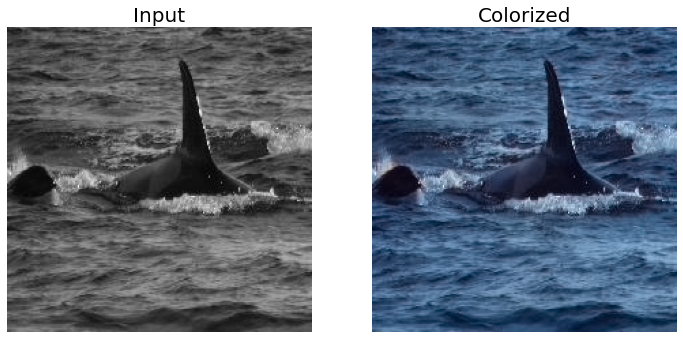

In [18]:
plot_output(test_img_0, color_img_0)

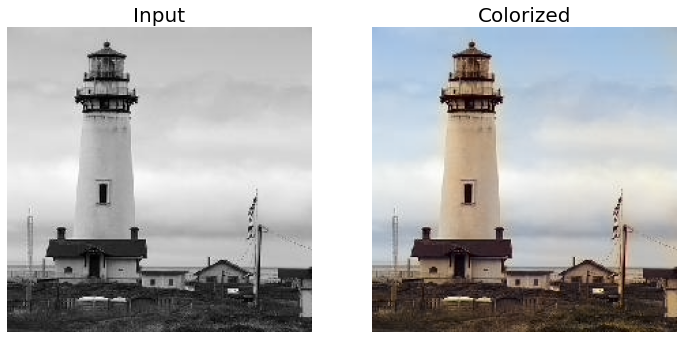

In [19]:
plot_output(test_img_1, color_img_1)

### Video Colorization

In [ ]:
def colorize_video(data_path: str) -> None:
    """
    Given a path for video input file, colorize each frame
    of video and save the colorized output video.

        Parameters:
            data_path (str): Local path for input video to be
                             colorized

        Returns:
            None
    """

    output_dir = "out"
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    output_path = f"{output_dir}/{os.path.basename(data_path)}"

    cap = cv2.VideoCapture(data_path)
    if not cap.isOpened():
        return

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc("M", "P", "4", "V")
    writer = cv2.VideoWriter(output_path, fourcc, 29.7, (w, h))
    i = 0
    elapsed = time.time()
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            colorized_frame = colorize(frame, infer_request)
            writer.write(colorized_frame)
        if i % 1000 == 0:
            print(
                f"frames processed: {i} - elpased_time: "
                f"{time.time() - elapsed} secs"
            )
            elapsed = time.time()
        i += 1

    if cap:
        cap.release()

    return None

In [ ]:
colorize_video("data/NY_BW.mp4")